# Import

In [1]:
import holidays

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pytorch_forecasting as pf
import torch
device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Process

In [2]:
def add_cyclical_calendar_features(df, features):
    """Cyclical encoding of calendar features
    NOTE datetime column must be set as index """

    if isinstance(features, str):
        features = [features]

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"
       
        if feat == "week":
            values = df.reset_index()["date"].dt.isocalendar().week.values.astype(float)
        else: values = getattr(df.index, feat)
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df

CALENDAR_CYCLES = {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [3]:
train_df = pd.read_csv("./train.csv", parse_dates=["date"])
test_df = pd.read_csv("./test.csv", parse_dates=["date"])

In [4]:
train_df = pd.read_csv("./train.csv", parse_dates=["date"])
test_df = pd.read_csv("./test.csv", parse_dates=["date"])

# Add weekend
train_df_processed = add_cyclical_calendar_features(train_df.set_index("date"), features=["weekday", "week"]) # Cyclic transformation
train_df_processed["weekend"] = (train_df_processed.index.dayofweek > 4).astype(int) # Flag indicating whether the date is a weekend or not

# Add holidays flag
holidays_dates_per_country = {}
for country in train_df_processed["country"].unique():
    holidays_dates_per_country[country]=[tuple[0] for tuple in list(getattr(holidays, country)(years=set(train_df_processed.index.year)).items())]
    train_df_processed.loc[train_df_processed["country"]==country, "holidays"]=train_df_processed.loc[train_df_processed["country"]==country].index.isin(holidays_dates_per_country[country])
train_df_processed["holidays"] = train_df_processed["holidays"].astype(int)

# Add end-of-year holidays flag
train_df_processed["newyear"]=0
for day in range(25,32):
    train_df_processed.loc[(train_df_processed.index.month == 12) & (train_df_processed.index.day == day),"newyear"]=1

# Add a year column
train_df_processed["year"]=train_df_processed.index.year

# Get average sales for each country in each year
mean_country_year = train_df_processed[['country', 'year', "num_sold"]].groupby(['country', 'year'], as_index=False).mean()
# Scale up the average sales of years 2017~2019 to match 2020
for country in train_df_processed.country.unique():
    mean_2020 = mean_country_year.loc[(mean_country_year['year'] == 2020) & (mean_country_year['country'] == country), 'num_sold'].values[0]

    for year in train_df_processed.year.unique():
        if year==2020:
            break
        mean_year = mean_country_year.loc[(mean_country_year['year'] == year) & (mean_country_year['country'] == country), 'num_sold'].values[0]
        factor = mean_2020/mean_year
        train_df_processed.loc[(train_df_processed["country"]==country) & (train_df_processed["year"]==year),"num_sold"]= train_df_processed.loc[(train_df_processed["country"]==country) & (train_df_processed["year"]==year),"num_sold"]*factor

# Handle 01-01-2020 outlier
train_df_processed[train_df_processed.index =='2020-01-01']
train_df_processed.loc[pd.Timestamp('2020-01-01'), "num_sold"]=np.nan

df_shifted = pd.concat(
        [train_df_processed[["num_sold"]].shift(periods=365*48*x) for x in range(3)], axis=1
    )
train_df_processed[["num_sold"]] = train_df_processed[["num_sold"]].fillna(df_shifted.groupby(by=df_shifted.columns, axis=1).mean())

# handle March~May outliers
train_df_processed.loc[(train_df_processed.year==2020)&(train_df_processed.index.month.isin([3,4,5])), "num_sold"]=np.nan

df_shifted = pd.concat(
        [train_df_processed[["num_sold"]].shift(periods=52*7*48*x) for x in range(3)], axis=1
    )
train_df_processed[["num_sold"]] = train_df_processed[["num_sold"]].fillna(df_shifted.groupby(by=df_shifted.columns, axis=1).mean())

# Scale up the average sales between 11-01-2020 and 29-02-2020 to minimize COVID19 effect
mean_country_slice = train_df_processed.loc[slice("2020-01-11", "2020-02-29"), ['country', "num_sold"]].groupby(['country'], as_index=False).mean()

for country in train_df_processed.country.unique():
    mean_2020 = mean_country_year.loc[(mean_country_year['year'] == 2020) & (mean_country_year['country'] == country), 'num_sold'].values[0]
    mean = mean_country_slice.loc[mean_country_slice["country"]==country, "num_sold"].values[0]
    factor = mean_2020/mean
    train_df_processed.loc[((train_df_processed["country"]==country) & (train_df_processed.index>="2020-01-11") &(train_df_processed.index<="2020-02-29")),"num_sold"]= train_df_processed.loc[((train_df_processed["country"]==country) & (train_df_processed.index>="2020-01-11") &(train_df_processed.index<="2020-02-29")),"num_sold"]*factor

train_df_processed["num_sold"] = train_df_processed["num_sold"].astype(float)
train = train_df_processed.reset_index()
train = (train.merge((train[['date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['date'])).drop(["date", "row_id"], axis=1)
train.head(3)

,country,store,product,num_sold,weekday_sin,weekday_cos,week_sin,week_cos,weekend,holidays,newyear,year,time_idx
0,Belgium,KaggleMart,Kaggle Advanced Techniques,623.047605,-0.781831,0.62349,6.432491e-16,1.0,1,1,0,2017,0
1,Belgium,KaggleMart,Kaggle Getting Started,577.940086,-0.781831,0.62349,6.432491e-16,1.0,1,1,0,2017,0
2,Belgium,KaggleMart,Kaggle Recipe Book,451.075189,-0.781831,0.62349,6.432491e-16,1.0,1,1,0,2017,0


In [5]:
max_prediction_length = 365 # a whole year
max_encoder_length = 365

# For training/evaluation splits
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020

# Create training set
training_dataset = pf.TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend', 'holidays', 'newyear'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['num_sold'],
    target_normalizer=pf.data.GroupNormalizer(
        groups=["country", "store", "product"], transformation="softplus"
    ),  # use softplus transformation and normalize by group
    lags={'num_sold': [7,365]}, # add lagged values of target variable
    # allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = pf.TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            train, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

# Train

In [6]:
# create training and validation dataloaders for model
batch_size = 128 
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [7]:
# Create network from TimeSeriesDataSet
model = pf.TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # number of quantiles
    loss=pf.metrics.QuantileLoss(),
    log_interval=10,  # logging every 10 batches
    reduce_on_plateau_patience=4,
).to(device)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


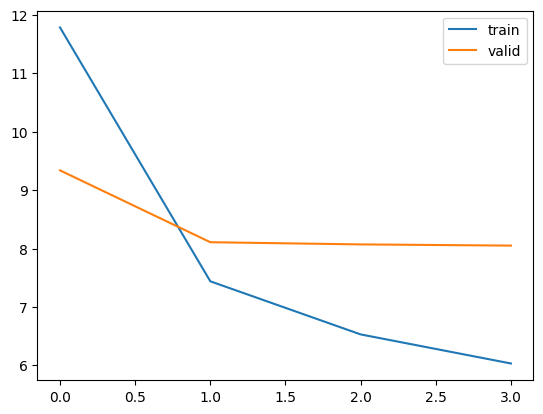

 4:17/138 mean_loss: 5.862799379560682

KeyboardInterrupt: 

: 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = pf.metrics.quantile.QuantileLoss()

def train(epoch):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Train
        optimizer.zero_grad()
        pred = model(x).prediction
        loss = loss_fn(pred, y[0].to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_loss: {mean_loss}", end="")

    print()
    return mean_loss

def val():
    model.eval()
    total_len = len(val_dataloader)
    total_loss = 0
    for n, data in enumerate(val_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Pred
        with torch.no_grad():
            pred = model(x).prediction
            loss = loss_fn(pred, y[0].to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            return mean_loss
 
def plot(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 15
train_loss_li, val_loss_li = [], []
for e in range(epoch):
    train_loss = train(e) # Train
    val_loss = val()

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    plot(train_loss_li, val_loss_li)

torch.Size([48, 365, 15])
torch.Size([48, 365])


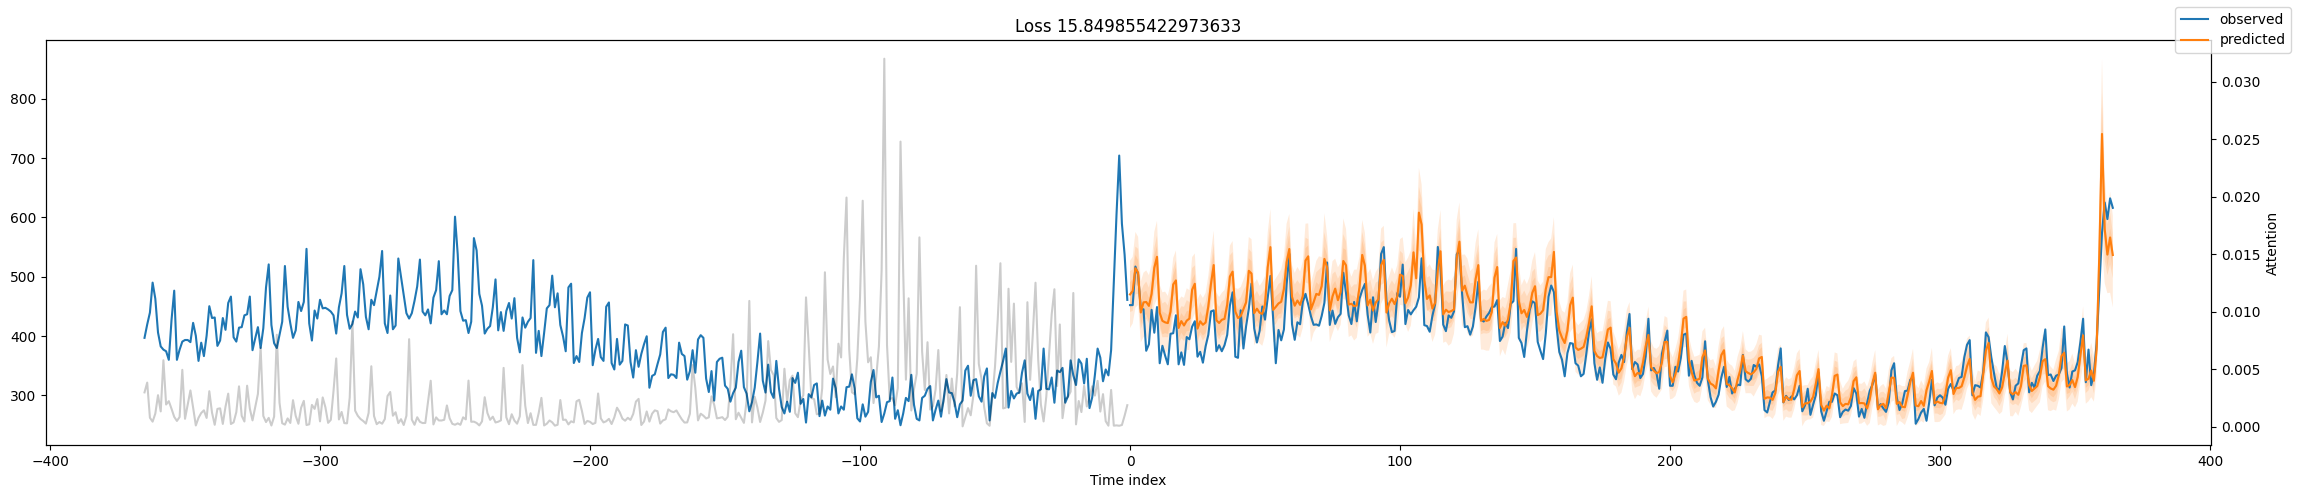

In [ ]:
for data in val_dataloader:
    x, y = data
    pred = model(x)
    print(x["encoder_cont"].shape)
    print(y[0].shape)

    fig, ax = plt.subplots(figsize=(23,5))
    model.plot_prediction(x, # network input
                        pred, # network output
                        idx=0,
                        add_loss_to_title=True,
                        ax=ax)